# UIN Project #2: Black-Box Optimization
**Author:** Martin Szuc  
**Algorithm:** Hybrid IPOP-CMA-ES with Adaptive Multi-Restart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cma
from scipy.optimize import minimize
import json
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Black-Box Function Import

In [2]:
%run black_box_bench.ipynb

black_box_bench(ones): 219.61221300466602


## Problem Configuration

In [3]:
max_evals = 100_000

DIM = 15
DIM_BLOCK = 5
BOUNDS_BLOCK_1 = (-5.12, 5.12)
BOUNDS_BLOCK_2 = (-32.768, 32.768)
BOUNDS_BLOCK_3 = (-5.0, 10.0)

bounds_lower = np.array([BOUNDS_BLOCK_1[0]]*5 + [BOUNDS_BLOCK_2[0]]*5 + [BOUNDS_BLOCK_3[0]]*5)
bounds_upper = np.array([BOUNDS_BLOCK_1[1]]*5 + [BOUNDS_BLOCK_2[1]]*5 + [BOUNDS_BLOCK_3[1]]*5)
bounds_range = bounds_upper - bounds_lower

# Tracking
eval_count = 0
best_x = None
best_f = float('inf')
history = []

## Parameters

In [4]:
SEED = 2024014

MAX_RESTARTS = 5
BASE_POPSIZE = 12
SIGMA_FACTOR = 0.3
POP_MULTIPLIER = 1.5
MAX_POPSIZE = 200

EARLY_STOP_THRESHOLD = 0.1  # if f < 0.1, stop restarts and starts refine

CMAES_BUDGET_RATIO = 0.67

TOL_FUN = 1e-12
TOL_FUN_HIST = 1e-13
LOCAL_XTOL = 1e-16
LOCAL_FTOL = 1e-16

LOCAL_METHOD = 'Nelder-Mead'

## Fitness Function

In [5]:
def fitness(x):
    global eval_count, best_x, best_f, history
    
    if eval_count >= max_evals:
        return best_f
    
    eval_count += 1
    x_clipped = np.clip(x, bounds_lower, bounds_upper)
    f_val = black_box_bench(x_clipped)
    
    if f_val < best_f:
        best_f = f_val
        best_x = x_clipped.copy()
    
    history.append(best_f)
    return f_val

## Hybrid IPOP-CMA-ES Optimizer

In [6]:
class HybridCMAESOptimizer:
    def __init__(self, bounds_lower, bounds_upper, max_evals, config):
        self.bounds_lower = bounds_lower
        self.bounds_upper = bounds_upper
        self.bounds_range = bounds_upper - bounds_lower
        self.max_evals = max_evals
        self.dim = len(bounds_lower)
        
        self.seed = config['seed']
        self.base_popsize = config['base_popsize']
        self.sigma0_factor = config['sigma_factor']
        self.max_restarts = config['max_restarts']
        self.pop_multiplier = config['pop_multiplier']
        self.max_popsize = config['max_popsize']
        self.tol_fun = config['tol_fun']
        self.tol_fun_hist = config['tol_fun_hist']
        self.local_method = config['local_method']
        self.local_xtol = config['local_xtol']
        self.local_ftol = config['local_ftol']
        self.cmaes_ratio = config['cmaes_ratio']
        self.early_stop_threshold = config['early_stop_threshold']
        
        np.random.seed(self.seed)
        self.restart_best = []
        self.restart_count = 0
        
    def generate_smart_x0(self, restart_num):
        if restart_num == 0:
            x0 = (self.bounds_lower + self.bounds_upper) / 2
            x0 += np.random.randn(self.dim) * 0.1 * self.bounds_range
        elif restart_num == 1:
            x0 = np.concatenate([np.ones(5) * 1.0, np.ones(5) * -1.5, np.ones(5) * 0.5])
            x0 += np.random.randn(self.dim) * 0.5
        elif restart_num == 2 and len(self.restart_best) > 0:
            x0 = self.restart_best[0][1].copy()
            x0 += np.random.randn(self.dim) * 0.05 * self.bounds_range
        else:
            x0 = np.random.uniform(self.bounds_lower, self.bounds_upper)
            if len(self.restart_best) > 0:
                alpha = np.random.uniform(0.3, 0.7)
                x0 = alpha * x0 + (1-alpha) * self.restart_best[0][1]
        
        return np.clip(x0, self.bounds_lower, self.bounds_upper)
    
    def run_cmaes_with_restarts(self, fitness_func, budget):
        remaining_budget = budget
        current_popsize = self.base_popsize
        
        for restart in range(self.max_restarts):
            if remaining_budget <= 0:
                break
                
            sigma0 = self.sigma0_factor * np.min(self.bounds_range)
            if restart > 0:
                sigma0 /= (restart + 1)
            
            x0 = self.generate_smart_x0(restart)
            
            opts = {
                'bounds': [list(self.bounds_lower), list(self.bounds_upper)],
                'popsize': current_popsize,
                'maxfevals': min(remaining_budget, budget // (self.max_restarts - restart)),
                'verbose': -9,
                'seed': self.seed + restart * 1000,
                'CMA_diagonal': True if restart % 2 == 1 else False,
                'tolfun': self.tol_fun,
                'tolfunhist': self.tol_fun_hist,
            }
            
            es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
            
            while not es.stop() and remaining_budget > 0:
                solutions = es.ask()
                solutions = [np.clip(s, self.bounds_lower, self.bounds_upper) for s in solutions]
                f_values = [fitness_func(x) for x in solutions]
                remaining_budget -= len(solutions)
                es.tell(solutions, f_values)
                
                if eval_count >= self.max_evals:
                    break
            
            # save restart results
            best_x = es.result.xbest
            best_f = es.result.fbest
            self.restart_best.append((best_f, best_x))
            
            # increase population for next restart (ipop)
            current_popsize = min(int(current_popsize * self.pop_multiplier), self.max_popsize)
            
            print(f"Restart {restart+1}: f = {best_f:.8f}, evals = {eval_count:,}")
            
            # early termination if solution is excellent
            if best_f < self.early_stop_threshold:
                remaining_for_polish = self.max_evals - eval_count
                print(f"  ★ near-optimal solution found (f<{self.early_stop_threshold})! Breaking to refine ({remaining_for_polish:,} evals left)")
                break
        
        # return best overall
        self.restart_best.sort(key=lambda x: x[0])
        return self.restart_best[0][1], self.restart_best[0][0]
    
    def local_refinement(self, x0, fitness_func, budget):
        # nelder-mead local search for final polish
        if budget <= 0:
            return x0
        
        result = minimize(
            fitness_func,
            x0,
            method=self.local_method,
            bounds=[(l, u) for l, u in zip(self.bounds_lower, self.bounds_upper)],
            options={
                'maxfev': budget,
                'xatol': self.local_xtol,
                'fatol': self.local_ftol,
                'adaptive': True,
            }
        )
        
        return result.x
    
    def optimize(self, fitness_func):
        global eval_count
        
        phase1_budget = int(self.cmaes_ratio * self.max_evals)
        best_x, best_f = self.run_cmaes_with_restarts(fitness_func, phase1_budget)
        
        print(f"CMA-ES complete: f={best_f:.6e} | evals={eval_count:,}")
        
        remaining_budget = self.max_evals - eval_count
        if remaining_budget > 10:
            print(f"Local refinement: {remaining_budget:,} evals...")
            best_x = self.local_refinement(best_x, fitness_func, remaining_budget)
            best_f = fitness_func(best_x)
            
            final_remaining = self.max_evals - eval_count
            if final_remaining > 10:
                print(f"Final polish ({final_remaining:,} evals left)...")
                while eval_count < self.max_evals - 5:
                    best_x = self.local_refinement(best_x, fitness_func, self.max_evals - eval_count)
                    new_f = fitness_func(best_x)
                    if new_f < best_f:
                        best_f = new_f
                    else:
                        break
            
            print(f"Complete: f={best_f:.6e} | evals={eval_count:,}")
        
        return best_x, best_f

## Main Optimization

In [7]:
eval_count = 0
best_x = None
best_f = float('inf')
history = []

np.random.seed(SEED)

config = {
    'seed': SEED,
    'max_restarts': MAX_RESTARTS,
    'base_popsize': BASE_POPSIZE,
    'sigma_factor': SIGMA_FACTOR,
    'pop_multiplier': POP_MULTIPLIER,
    'max_popsize': MAX_POPSIZE,
    'tol_fun': TOL_FUN,
    'tol_fun_hist': TOL_FUN_HIST,
    'local_method': LOCAL_METHOD,
    'local_xtol': LOCAL_XTOL,
    'local_ftol': LOCAL_FTOL,
    'cmaes_ratio': CMAES_BUDGET_RATIO,
    'early_stop_threshold': EARLY_STOP_THRESHOLD,
}

optimizer = HybridCMAESOptimizer(bounds_lower, bounds_upper, max_evals, config)
x_opt, f_opt = optimizer.optimize(fitness)

print("="*60)
print(f"Optimization complete: f(x) = {f_opt:.8e}")

Restart 1: f = 24.22594476, evals = 9,288
Restart 2: f = 0.04209251, evals = 26,046
  ★ near-optimal solution found (f<0.1)! Breaking to refine (73,954 evals left)
CMA-ES complete: f=4.209251e-02 | evals=26,046
Local refinement: 73,954 evals...
Complete: f=6.665856e-15 | evals=100,000
Optimization complete: f(x) = 6.66585630e-15


## Final Results & Analysis

In [8]:
# Helper function to format numbers with 18 decimal places and grouping
def format_number(num):
    """Format number with exactly 18 decimal places and thousands separators"""
    sign = '-' if num < 0 else ''
    num_abs = abs(num)
    # Split into integer and decimal parts
    int_part = int(num_abs)
    dec_part = num_abs - int_part
    # Format integer part with commas (thousands separators)
    int_str = f"{int_part:,}"
    # Format decimal part with exactly 18 places
    dec_str = f"{dec_part:.18f}".split('.')[1]
    # Ensure exactly 18 decimal places (pad with zeros if needed)
    dec_str = dec_str[:18].ljust(18, '0')
    return f"{sign}{int_str}.{dec_str}"

print("\nRESULTS")
print("="*60)

print("Block 1 (Rastrigin):")
for i in range(5):
    print(f"  x[{i}] = {format_number(x_opt[i])}")

print("\nBlock 2 (Ackley):")
for i in range(5, 10):
    print(f"  x[{i}] = {format_number(x_opt[i])}")

print("\nBlock 3 (Rosenbrock):")
for i in range(10, 15):
    print(f"  x[{i}] = {format_number(x_opt[i])}")

print(f"\nf(x_opt) = {format_number(f_opt)}")
print(f"Evaluations: {eval_count:,} / {max_evals:,}")
print(f"Seed: {SEED}")

# Verify bounds
all_ok = True
for i in range(5):
    if not (-5.12 <= x_opt[i] <= 5.12):
        all_ok = False
for i in range(5, 10):
    if not (-32.768 <= x_opt[i] <= 32.768):
        all_ok = False
for i in range(10, 15):
    if not (-5.0 <= x_opt[i] <= 10.0):
        all_ok = False

print(f"\nConstraints: {'All satisfied' if all_ok else 'VIOLATION'}")

with open('optimization_results.txt', 'w') as f:
    f.write("UIN Project #2 - Optimization Results\n")
    f.write("="*50 + "\n\n")
    f.write(f"Seed: {SEED}\n")
    f.write(f"Evaluations: {eval_count:,}\n\n")
    f.write("Solution:\n")
    for i in range(15):
        f.write(f"x[{i:2d}] = {format_number(x_opt[i])}\n")
    f.write(f"\nf(x_opt) = {format_number(f_opt)}\n")


RESULTS
Block 1 (Rastrigin):
  x[0] = 0.999999998543188107
  x[1] = 1.000000000030109248
  x[2] = 0.999999993976017021
  x[3] = 0.999999999855026633
  x[4] = 0.999999999106544690

Block 2 (Ackley):
  x[5] = -1.500000000000000444
  x[6] = -1.499999999999999778
  x[7] = -1.500000000000000000
  x[8] = -1.499999999999999778
  x[9] = -1.499999999999999778

Block 3 (Rosenbrock):
  x[10] = 0.500000008948408459
  x[11] = 0.500000003535974624
  x[12] = 0.500000037563611111
  x[13] = 0.499999971604511206
  x[14] = 0.500000002918007280

f(x_opt) = 0.000000000000006666
Evaluations: 100,000 / 100,000
Seed: 2024014

Constraints: All satisfied


## Visualization

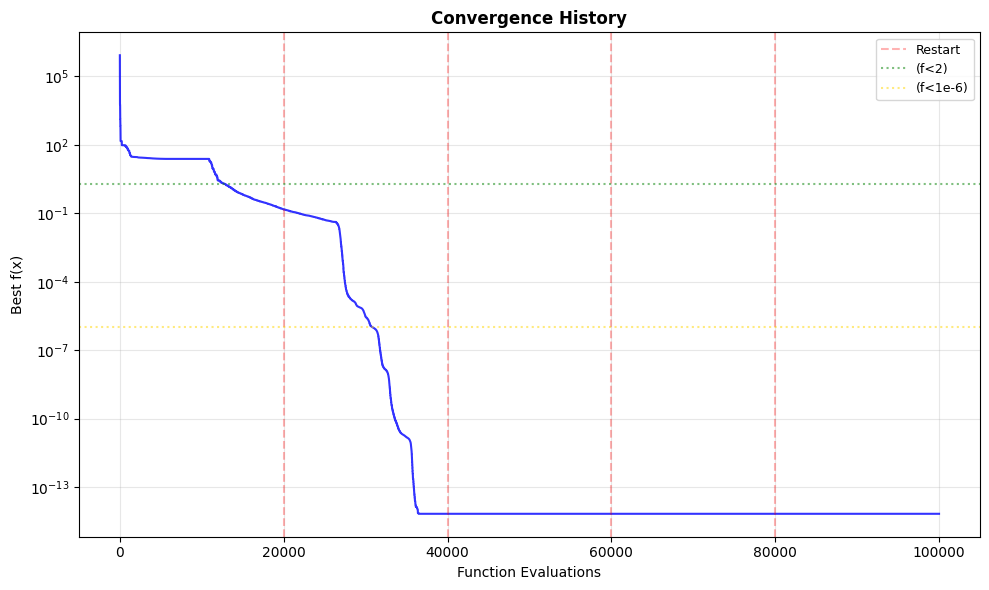

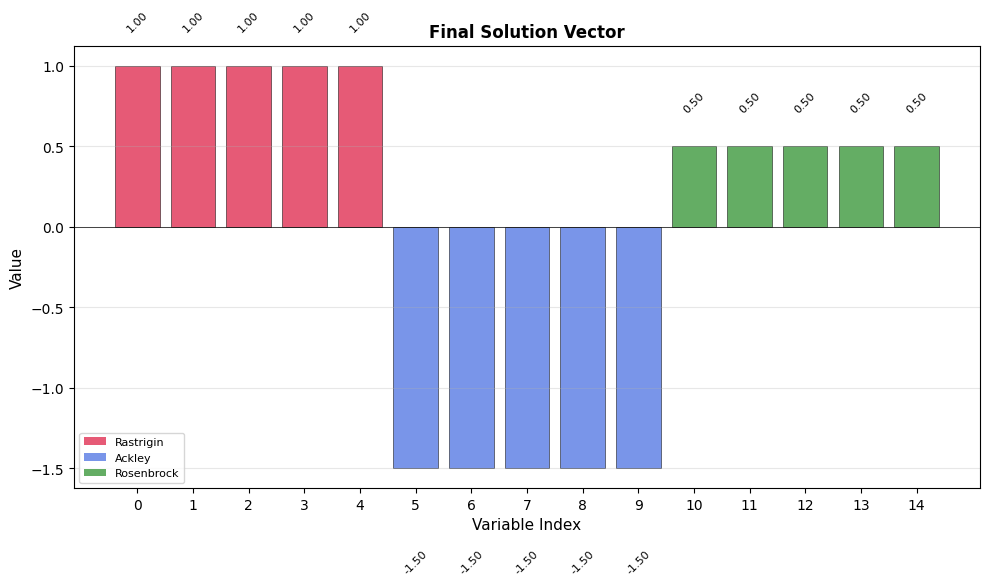

In [9]:
    # Plot 1: Convergence history
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogy(history, 'b-', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Function Evaluations')
ax1.set_ylabel('Best f(x)')
ax1.set_title('Convergence History', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

for i in range(1, MAX_RESTARTS):
    restart_point = i * len(history) // MAX_RESTARTS
    if restart_point < len(history):
        ax1.axvline(x=restart_point, color='r', linestyle='--', alpha=0.3, 
                    label='Restart' if i==1 else '')

ax1.axhline(y=2.0, color='g', linestyle=':', alpha=0.5, label='(f<2)')
ax1.axhline(y=1e-6, color='gold', linestyle=':', alpha=0.5, label='(f<1e-6)')
ax1.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('convergence_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Solution vector
fig2, ax2 = plt.subplots(figsize=(10, 6))
x_indices = np.arange(15)
colors = ['crimson']*5 + ['royalblue']*5 + ['forestgreen']*5

bars = ax2.bar(x_indices, x_opt, color=colors, alpha=0.7, 
               edgecolor='black', linewidth=0.5)

for i, (bar, val) in enumerate(zip(bars, x_opt)):
    height = bar.get_height()
    y_pos = height + 0.2 if height > 0 else height - 0.5
    ax2.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.2f}', 
             ha='center', va='bottom' if height > 0 else 'top', 
             fontsize=8, rotation=45)

ax2.set_xlabel('Variable Index', fontsize=11)
ax2.set_ylabel('Value', fontsize=11)
ax2.set_title('Final Solution Vector', fontsize=12, fontweight='bold')
ax2.set_xticks(x_indices)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linewidth=0.5)

legend_elements = [
    Patch(facecolor='crimson', alpha=0.7, label='Rastrigin'),
    Patch(facecolor='royalblue', alpha=0.7, label='Ackley'),
    Patch(facecolor='forestgreen', alpha=0.7, label='Rosenbrock')
]
ax2.legend(handles=legend_elements, loc='best', fontsize=8)

plt.tight_layout()
plt.savefig('solution_vector.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
from datetime import datetime

result_entry = {
    "timestamp": datetime.now().isoformat(),
    "f_value": float(f_opt),
    "evaluations": int(eval_count),
    "seed": int(SEED),
    "solution": x_opt.tolist(),
    "config": {
        "restarts": MAX_RESTARTS,
        "budget_split": f"{CMAES_BUDGET_RATIO:.0%}/{1-CMAES_BUDGET_RATIO:.0%}",
        "local_method": LOCAL_METHOD,
        "sigma_factor": SIGMA_FACTOR
    }
}

try:
    with open('results_database.json', 'r') as f:
        results = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    results = []

results.append(result_entry)

with open('results_database.json', 'w') as f:
    json.dump(results, f, indent=2)

# Helper function to format numbers with 18 decimal places and grouping
def format_number(num):
    """Format number with exactly 18 decimal places and thousands separators"""
    sign = '-' if num < 0 else ''
    num_abs = abs(num)
    # Split into integer and decimal parts
    int_part = int(num_abs)
    dec_part = num_abs - int_part
    # Format integer part with commas (thousands separators)
    int_str = f"{int_part:,}"
    # Format decimal part with exactly 18 places
    dec_str = f"{dec_part:.18f}".split('.')[1]
    # Ensure exactly 18 decimal places (pad with zeros if needed)
    dec_str = dec_str[:18].ljust(18, '0')
    return f"{sign}{int_str}.{dec_str}"

with open('optimization_results.txt', 'w') as f:
    f.write("UIN Project #2 - Optimization Results\n")
    f.write("="*50 + "\n\n")
    f.write(f"Seed: {SEED}\n")
    f.write(f"Evaluations: {eval_count:,} / {max_evals:,}\n\n")
    f.write("Solution:\n")
    for i in range(15):
        f.write(f"x[{i:2d}] = {format_number(x_opt[i])}\n")
    f.write(f"\nf(x_opt) = {format_number(f_opt)}\n")